In [1]:
import numpy as np
import pandas as pd
import gzip
from sklearn import svm
import cv2
from sklearn.metrics import accuracy_score
from sklearn.utils import  shuffle

In [2]:
def load_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16)
    return images.reshape(-1, 28, 28)/255.0


def load_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels


train_images = load_images('手写数字/train-images-idx3-ubyte.gz')
train_labels = load_labels('手写数字/train-labels-idx1-ubyte.gz')
test_images = load_images('手写数字/t10k-images-idx3-ubyte.gz')
test_labels = load_labels('手写数字/t10k-labels-idx1-ubyte.gz')

train_images,train_labels=shuffle(train_images,train_labels,random_state=42)
test_images, test_labels = shuffle(test_images, test_labels, random_state=42)


In [3]:
# 创建空数组用于存放调整后的图像
train_images_resized = np.zeros((train_images.shape[0], 20, 20))

for i in range(train_images.shape[0]):
    # 使用 OpenCV 进行缩放
    train_images_resized[i] = cv2.resize(train_images[i], (20, 20))

# 创建空数组用于存放调整后的图像
test_images_resized = np.zeros((test_images.shape[0], 20, 20))

for i in range(test_images.shape[0]):
    # 使用 OpenCV 进行缩放
    test_images_resized[i] = cv2.resize(test_images[i], (20, 20))

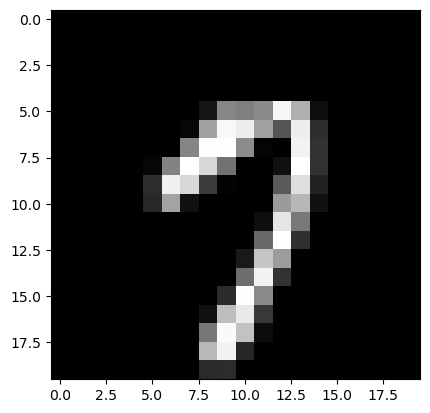

In [5]:
import matplotlib.pyplot as plt

plt.imshow(train_images_resized[7],cmap='gray')
plt.show()

In [18]:
import ot  # 导入 POT 库

# 2. 选择标签为 0 和 1 的图像，并各取一个样本
X1 = train_images_resized[train_labels == 2][10]  # 取第一个标签为 0 的样本
X2 = train_images_resized[train_labels == 2][10]  # 取第一个标签为 1 的样本

# 3. 计算两个图像之间的代价矩阵
# 假设 X1 和 X2 都是展平后的图像向量 (784,)
# 这里我们使用像素之间的平方欧氏距离作为代价矩阵
X1 = X1.reshape(-1, 1)  # 将图像 X1 展平为 (400, 1)
X2 = X2.reshape(-1, 1)  # 将图像 X2 展平为 (400, 1)
cost_matrix = ot.dist(X1, X2, metric='euclidean')  # 计算平方欧氏距离作为代价矩阵

# 4. 定义两个图像的权重分布（均匀分布）
r = np.ones(X1.shape[0]) / X1.shape[0]  # 源分布权重 (784,)
c = np.ones(X2.shape[0]) / X2.shape[0]  # 目标分布权重 (784,)

# 5. 计算 Sinkhorn 距离
# 使用 ot.sinkhorn2 方法计算带有正则化的 Sinkhorn 距离
sinkhorn_distance = ot.sinkhorn2(r, c, cost_matrix, reg=1e-3)


print(f"Sinkhorn Distance: {sinkhorn_distance}")


Sinkhorn Distance: 5.378370809838502e-05


In [21]:
c.shape

(400,)

In [18]:
def sinkhorn_kernel(X,Y,gamma=10):
    n=X.shape[0]
    m = Y.shape[0]
    #初始化核矩阵
    kernel_matrix = np.zeros((n,m))
    # 逐对样本计算 Sinkhorn 距离，并转化为相似度
    for i in range(n):
        for j in range(m):
            M=ot.dist(X[i], Y[j], metric='euclidean')
            r = np.ones(X[i].shape[0]) / X[i].shape[0]  # 源分布权重 (400,)
            c = np.ones(Y[j].shape[0]) / Y[j].shape[0]  # 目标分布权重 (400,)
            sinkhorn_distance = ot.sinkhorn2(r, c, M, reg=9,stopThr=1e-9)
            #论文里k=exp(-reg*M)
            #库函数是 K = nx.exp(M / (-reg))
            # 使用 RBF 核公式将距离转化为相似度
            kernel_matrix[i, j] = np.exp(-gamma * sinkhorn_distance)
            #内核exp(-d/t)
    
    return kernel_matrix
    

In [6]:
def emd_kernel(X, Y, gamma=0.1):
    n = X.shape[0]
    m = Y.shape[0]

    # 初始化核矩阵
    kernel_matrix = np.zeros((n, m))

    # 逐对样本计算 EMD 距离，并转化为相似度
    for i in range(n):
        for j in range(m):
            # 计算样本 i 和样本 j 之间的欧几里得距离矩阵
            M = ot.dist(X[i], Y[j], metric='euclidean')

            # 设置源分布和目标分布的权重，权重和为 1
            r = np.ones(X[i].shape[0]) / X[i].shape[0]  # 源分布权重 (d,)
            c = np.ones(Y[j].shape[0]) / Y[j].shape[0]  # 目标分布权重 (d,)

            # 计算 EMD 距离
            emd_distance = ot.emd2(r, c, M)

            # 使用 RBF 核公式将距离转化为相似度
            kernel_matrix[i, j] = np.exp(-gamma * emd_distance)

    return kernel_matrix

In [7]:
import numpy as np
import ot  # 需要安装 POT 库来使用 ot 模块

def ind_kernel(X, Y, gamma=0.1):
    n = X.shape[0]
    m = Y.shape[0]

    # 初始化核矩阵
    kernel_matrix = np.zeros((n, m))

    # 逐对样本计算 Independent Wasserstein Distance，并转化为相似度
    for i in range(n):
        for j in range(m):
            # 将样本 i 和样本 j 看作独立维度上的分布
            # 计算每个特征维度上的 Wasserstein 距离并求和
            ind_distance = 0
            for k in range(X.shape[1]):
                # 计算样本 i 和样本 j 在第 k 个维度上的 Wasserstein 距离
                M = ot.dist(X[i, k], Y[j, k], metric='euclidean')
                r = np.ones(X[i, k].shape) / X[i, k].shape[0]
                c = np.ones(Y[j, k].shape) / Y[j, k].shape[0]

                # 计算第 k 维度的 EMD 距离
                ind_distance += ot.emd2(r, c, M)
            
            # 使用 RBF 核公式将距离转化为相似度
            kernel_matrix[i, j] = np.exp(-gamma * ind_distance)

    return kernel_matrix


In [8]:
def hellinger_kernel(X, Y, gamma=0.1):
    n = X.shape[0]
    m = Y.shape[0]
    # 初始化核矩阵
    kernel_matrix = np.zeros((n, m))
    # 逐对样本计算 Hellinger 距离，并转化为相似度
    for i in range(n):
        for j in range(m):
            # 计算两个分布的 Hellinger 距离
            P = X[i] / np.sum(X[i])  # 确保 X[i] 是概率分布
            Q = Y[j] / np.sum(Y[j])  # 确保 Y[j] 是概率分布
            hellinger_distance = np.sqrt(np.sum((np.sqrt(P) - np.sqrt(Q))**2)) / np.sqrt(2)
            # 使用 RBF 核公式将 Hellinger 距离转化为相似度
            kernel_matrix[i, j] = np.exp(-gamma * hellinger_distance)
    
    return kernel_matrix


In [9]:
def chi2_kernel(X, Y, gamma=0.1):
    n = X.shape[0]
    m = Y.shape[0]
    # 初始化核矩阵
    kernel_matrix = np.zeros((n, m))
    # 逐对样本计算 χ² 距离，并转化为相似度
    for i in range(n):
        for j in range(m):
            P = X[i] / np.sum(X[i])  # 确保 X[i] 是概率分布
            Q = Y[j] / np.sum(Y[j])  # 确保 Y[j] 是概率分布
            # 避免除以零，P + Q 不能为零
            chi2_distance = 0.5 * np.sum((P - Q) ** 2 / (P + Q + 1e-8))
            # 使用 RBF 核公式将 χ² 距离转化为相似度
            kernel_matrix[i, j] = np.exp(-gamma * chi2_distance)
    
    return kernel_matrix

In [10]:
def tv_kernel(X, Y, gamma=0.1):
    n = X.shape[0]
    m = Y.shape[0]
    # 初始化核矩阵
    kernel_matrix = np.zeros((n, m))
    # 逐对样本计算 TV 距离，并转化为相似度
    for i in range(n):
        for j in range(m):
            P = X[i] / np.sum(X[i])  # 确保 X[i] 是概率分布
            Q = Y[j] / np.sum(Y[j])  # 确保 Y[j] 是概率分布
            # 计算 TV 距离
            tv_distance = 0.5 * np.sum(np.abs(P - Q))
            # 使用 RBF 核公式将 TV 距离转化为相似度
            kernel_matrix[i, j] = np.exp(-gamma * tv_distance)
    
    return kernel_matrix


In [9]:
def squared_euclidean_kernel(X, Y, gamma=0.1):
    n = X.shape[0]
    m = Y.shape[0]
    # 初始化核矩阵
    kernel_matrix = np.zeros((n, m))
    
    # 逐对样本计算平方欧几里得距离，并转化为相似度
    for i in range(n):
        for j in range(m):
            # 计算平方欧几里得距离
            squared_distance = np.sum((X[i] - Y[j]) ** 2)
            # 使用 RBF 核公式将距离转化为相似度
            kernel_matrix[i, j] = np.exp(-gamma * squared_distance)
    
    return kernel_matrix


In [47]:
#train_images=train_images_resized.reshape(train_images_resized.shape[0], 400,1)
#test_images=test_images_resized.reshape(test_images_resized.shape[0], 400,1)

In [12]:
train_images.shape

(60000, 28, 28)

In [10]:
train_images_1000=train_images_resized[:1000]
train_labels_1000=train_labels[:1000]
test_images_1000=test_images_resized[:1000]
test_labels_1000=test_labels[:1000]

In [11]:
train_images_3000=train_images_resized[:3000]
train_labels_3000=train_labels[:3000]
test_images_3000=test_images_resized[:3000]
test_labels_3000=test_labels[:3000]

In [12]:
train_images_5000=train_images_resized[:5000]
train_labels_5000=train_labels[:5000]
test_images_5000=test_images_resized[:5000]
test_labels_5000=test_labels[:5000]

In [18]:
# 计算训练集和测试集的 Sinkhorn 核矩阵 1000个样本 stopThr=1e-9

train_kernel_matrix = sinkhorn_kernel(train_images_1000, train_images_1000)
test_kernel_matrix = sinkhorn_kernel(test_images_1000, train_images_1000)  # 注意这里是测试集和训练集计算

# 4. 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_1000)

# 5. 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

# 6. 评估模型性能
accuracy = accuracy_score(test_labels_1000, test_preds)
print(f"SVM + Sinkhorn Kernel Accuracy: {accuracy:.4f}")


SVM + Sinkhorn Kernel Accuracy: 0.3000


In [19]:
# 计算训练集和测试集的 Sinkhorn 核矩阵 1000个样本 stopThr=1e-2

train_kernel_matrix = sinkhorn_kernel(train_images_1000, train_images_1000)
test_kernel_matrix = sinkhorn_kernel(test_images_1000, train_images_1000)  # 注意这里是测试集和训练集计算

# 4. 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_1000)

# 5. 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

# 6. 评估模型性能
accuracy = accuracy_score(test_labels_1000, test_preds)
print(f"SVM + Sinkhorn Kernel Accuracy: {accuracy:.4f}")


SVM + Sinkhorn Kernel Accuracy: 0.0970


In [21]:
train_kernel_matrix

array([[2.11968720e-06, 2.26485009e-07, 1.34831346e-07, ...,
        5.33312887e-07, 4.58686325e-08, 8.01699105e-07],
       [2.26526737e-07, 2.97078918e-07, 1.34308920e-07, ...,
        2.74596966e-07, 5.54350440e-08, 2.36952967e-07],
       [1.34835806e-07, 1.34316639e-07, 2.73471200e-07, ...,
        2.04164494e-07, 6.32745426e-08, 2.16357445e-07],
       ...,
       [5.33366716e-07, 2.74585698e-07, 2.04160333e-07, ...,
        7.35561027e-07, 7.18344048e-08, 5.47037737e-07],
       [4.58743149e-08, 5.54373191e-08, 6.32736697e-08, ...,
        7.18363923e-08, 5.73930520e-08, 6.59953400e-08],
       [8.01732366e-07, 2.36957384e-07, 2.16362187e-07, ...,
        5.47041980e-07, 6.59930539e-08, 1.44349882e-06]])

In [14]:
# 计算训练集和测试集的 Sinkhorn 核矩阵 3000个样本

train_kernel_matrix = sinkhorn_kernel(train_images_3000, train_images_3000)
test_kernel_matrix = sinkhorn_kernel(test_images_3000, train_images_3000)  # 注意这里是测试集和训练集计算

# 4. 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_3000)

# 5. 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

# 6. 评估模型性能
accuracy = accuracy_score(test_labels_3000, test_preds)
print(f"SVM + Sinkhorn Kernel Accuracy: {accuracy:.4f}")


SVM + Sinkhorn Kernel Accuracy: 0.4640


In [ ]:
# 计算训练集和测试集的 Sinkhorn 核矩阵 5000个样本

train_kernel_matrix = sinkhorn_kernel(train_images_5000, train_images_5000)
test_kernel_matrix = sinkhorn_kernel(test_images_5000, train_images_5000)  # 注意这里是测试集和训练集计算

# 4. 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_5000)

# 5. 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

# 6. 评估模型性能
accuracy = accuracy_score(test_labels_5000, test_preds)
print(f"SVM + Sinkhorn Kernel Accuracy: {accuracy:.4f}")


In [19]:
# 计算训练集和测试集的 Emd 核矩阵 1000
train_kernel_matrix = emd_kernel(train_images_1000, train_images_1000)
test_kernel_matrix = emd_kernel(test_images_1000, train_images_1000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_1000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_1000, test_preds)
print(f"SVM + Emd Kernel Accuracy: {accuracy:.4f}")

SVM + Emd Kernel Accuracy: 0.5570


In [14]:
# 计算训练集和测试集的 Emd 核矩阵  3000
train_kernel_matrix = emd_kernel(train_images_3000, train_images_3000)
test_kernel_matrix = emd_kernel(test_images_3000, train_images_3000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_3000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_3000, test_preds)
print(f"SVM + Emd Kernel Accuracy: {accuracy:.4f}")

SVM + Emd Kernel Accuracy: 0.7490


In [52]:
# 计算训练集和测试集的 hellinger 核矩阵 1000
train_kernel_matrix = hellinger_kernel(train_images_1000, train_images_1000)
test_kernel_matrix = hellinger_kernel(test_images_1000, train_images_1000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_1000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_1000, test_preds)
print(f"SVM + Hell Kernel Accuracy: {accuracy:.4f}")

SVM + Hell Kernel Accuracy: 0.7270


In [14]:
#3000
train_kernel_matrix = hellinger_kernel(train_images_3000, train_images_3000)
test_kernel_matrix = hellinger_kernel(test_images_3000, train_images_3000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_3000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_3000, test_preds)
print(f"SVM + Hell Kernel Accuracy: {accuracy:.4f}")

SVM + Hell Kernel Accuracy: 0.8963


In [15]:
#5000
train_kernel_matrix = hellinger_kernel(train_images_5000, train_images_5000)
test_kernel_matrix = hellinger_kernel(test_images_5000, train_images_5000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_5000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_5000, test_preds)
print(f"SVM + Hell Kernel Accuracy: {accuracy:.4f}")

SVM + Hell Kernel Accuracy: 0.9130


In [53]:
# 计算训练集和测试集的 chi2 核矩阵 1000
train_kernel_matrix = chi2_kernel(train_images_1000, train_images_1000)
test_kernel_matrix = chi2_kernel(test_images_1000, train_images_1000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_1000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_1000, test_preds)
print(f"SVM + chi Kernel Accuracy: {accuracy:.4f}")

SVM + chi Kernel Accuracy: 0.7720


In [20]:
train_kernel_matrix = chi2_kernel(train_images_3000, train_images_3000)
test_kernel_matrix = chi2_kernel(test_images_3000, train_images_3000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_3000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_3000, test_preds)
print(f"SVM + chi Kernel Accuracy: {accuracy:.4f}")

SVM + chi Kernel Accuracy: 0.8850


In [21]:
train_kernel_matrix = chi2_kernel(train_images_5000, train_images_5000)
test_kernel_matrix = chi2_kernel(test_images_5000, train_images_5000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_5000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_5000, test_preds)
print(f"SVM + chi Kernel Accuracy: {accuracy:.4f}")

SVM + chi Kernel Accuracy: 0.9042


In [54]:
# 计算训练集和测试集的 tv 核矩阵
train_kernel_matrix = tv_kernel(train_images_1000, train_images_1000)
test_kernel_matrix = tv_kernel(test_images_1000, train_images_1000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_1000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_1000, test_preds)
print(f"SVM + tv Kernel Accuracy: {accuracy:.4f}")

SVM + tv Kernel Accuracy: 0.7300


In [18]:
train_kernel_matrix = tv_kernel(train_images_3000, train_images_3000)
test_kernel_matrix = tv_kernel(test_images_3000, train_images_3000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_3000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_3000, test_preds)
print(f"SVM + tv Kernel Accuracy: {accuracy:.4f}")

SVM + tv Kernel Accuracy: 0.8807


In [19]:
train_kernel_matrix = tv_kernel(train_images_5000, train_images_5000)
test_kernel_matrix = tv_kernel(test_images_5000, train_images_5000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_5000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_5000, test_preds)
print(f"SVM + tv Kernel Accuracy: {accuracy:.4f}")

SVM + tv Kernel Accuracy: 0.8998


In [13]:
# 计算训练集和测试集的 squared_euclidean_kernel 核矩阵
train_kernel_matrix = squared_euclidean_kernel(train_images_1000, train_images_1000)
test_kernel_matrix = squared_euclidean_kernel(test_images_1000, train_images_1000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_1000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_1000, test_preds)
print(f"SVM + squared_euclidean_kernel Accuracy: {accuracy:.4f}")

SVM + squared_euclidean_kernel Accuracy: 0.9230


In [14]:
# 计算训练集和测试集的 squared_euclidean_kernel 核矩阵
train_kernel_matrix = squared_euclidean_kernel(train_images_3000, train_images_3000)
test_kernel_matrix = squared_euclidean_kernel(test_images_3000, train_images_3000)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, train_labels_3000)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

#评估模型性能
accuracy = accuracy_score(test_labels_3000, test_preds)
print(f"SVM + squared_euclidean_kernel Accuracy: {accuracy:.4f}")

SVM + squared_euclidean_kernel Accuracy: 0.9513
